In [2]:
import numpy as np
import os
import pandas as pd
import shap
import xgboost
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
shap.initjs() # Don't worry if this doesn't work for you. Comment it out and carry on

# conda install pytorch::pytorch
# conda install pytorch::torchvision 
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torch.nn.functional as F

# Tabular data

## Data and model

In the diabetes dataset, each y value reflects how much a patient’s condition progressed after a year

In [3]:
X_data, y_data = load_diabetes(scaled=False, as_frame=True, return_X_y=True)
features = X_data.columns.to_numpy()
features

array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
      dtype=object)

In [4]:
# I also love np arrays, but keep the dataframe structure if you want feature names on your SHAP plot
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [5]:
regressor = xgboost.XGBRegressor()
regressor.fit(x_train, y_train);

## SHAP explainer and plot

Initialise explainer on the model, and (for now) specify a background data set.
This causes SHAP to estimate the expectation by marginalising missing features independently (using the background data), thus breaking empirical feature correlations

In [6]:
explainer = shap.TreeExplainer(regressor, data=x_train)
shap_values = explainer.shap_values(x_test)

First, make the typical SHAP plot. 
Remember from yesterday's Shapley values that bmi was important, while age was (up to third) least important

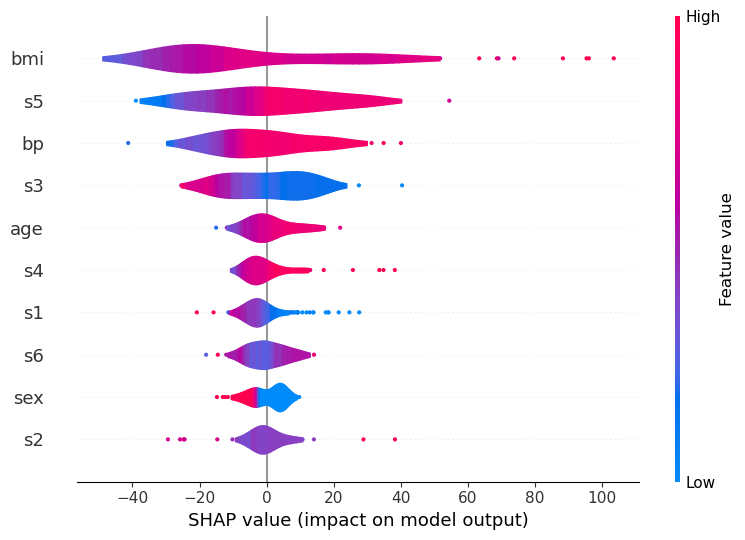

In [7]:
shap.summary_plot(shap_values, x_test, plot_type="violin")

Let's look closer at a single instance and use SHAP to explain the prediction

In [10]:
y_pred = regressor.predict(x_test)
index = 2
print("Mean BMI in test data:", np.mean(x_test.bmi))
print("Mean prediction on test data:", np.mean(y_pred))
print("Prediction on our data point:", y_pred[index])
print("Data point:")
print(x_test.iloc[index])

shap.force_plot(explainer.expected_value, shap_values[index,:], x_test.iloc[index,:])

Mean BMI in test data: 26.043150684931508
Mean prediction on test data: 149.2698
Prediction on our data point: 126.554016
Data point:
age     66.0000
sex      2.0000
bmi     26.0000
bp      91.0000
s1     264.0000
s2     146.6000
s3      65.0000
s4       4.0000
s5       5.5683
s6      87.0000
Name: 72, dtype: float64


In [23]:
print(explainer.expected_value)
print(sum(shap_values[index, :]))
print(regressor.predict(x_test)[index])
print(explainer.expected_value + sum(shap_values[index, :]))

154.44574596805717
-27.891726560560564
126.554016
126.55401940749661


In [24]:
print("Base value + sum of the SHAP values=", explainer.expected_value + sum(shap_values[index,:]))

Base value + sum of the SHAP values= 126.55401940749661


Remember that the base value represents the expected model prediction without any feature values, so the mean prediction on the background data (in our case the training data). Check if this is the case:

In [25]:
base = explainer.expected_value
mean_pred = regressor.predict(x_train).mean()
mean_y = y_train.mean()
print("Base value:", base, "\nMean prediction on training data:", mean_pred)

Base value: 154.44574596805717 
Mean prediction on training data: 151.98286


The two values are not exactly equal because the base value is estimated assuming feature independence.

If we instead let SHAP use the tree to estimate this value, it aligns more closely with the actual prediction on the test data.

In [26]:
explainer = shap.TreeExplainer(regressor, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(x_test)
base = explainer.expected_value
mean_pred = regressor.predict(x_train).mean()
print("Base value:", base, "\nMean prediction on training data:", mean_pred)

Base value: 151.98288 
Mean prediction on training data: 151.98286


# MNIST

In [27]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", 
        train=False, 
        transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

B (Batch size): 64,

C (Channels): 1,

H (Height): 28,

W (Width): 28

In [28]:
# This cell is just for understanding the data loader objects
imgs, lbls = next(iter(test_loader))
print(imgs.shape)  # torch.Size([B, C, H, W])
print(lbls.shape)  # torch.Size([B])

torch.Size([64, 1, 28, 28])
torch.Size([64])


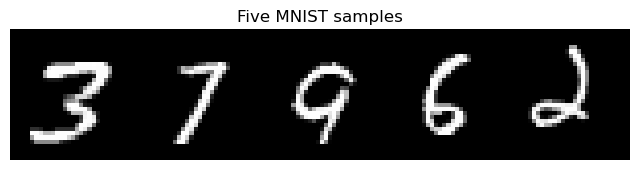

In [29]:
# This cell is just for looking at some of the images
from torchvision.utils import make_grid
imgs5 = imgs[:5]

# Make a grid and plot
grid = make_grid(imgs5, nrow=5, padding=2)
plt.figure(figsize=(8, 2))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Five MNIST samples")
plt.show()

### Train/load and test a simple pytorch model

In [30]:
num_epochs = 5
device = torch.device("cpu")

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

model_file = "mnist_cnn.pt"

if os.path.isfile(model_file):
    print(f"Found model file {model_file}. Loading...")
    state = torch.load(model_file, map_location=device, weights_only=True)
    model.load_state_dict(state, strict=True)
    test(model, device, test_loader)

else:
    print(f"Found no model saved as {model_file}. Training...")
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        torch.save(model.state_dict(), model_file)
        test(model, device, test_loader)


Found model file mnist_cnn.pt. Loading...

Test set: Average loss: 0.0015, Accuracy: 9751/10000 (98%)



Use the model to predict on test data

Label: 1
Prediction: 1
Probabilities: [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]


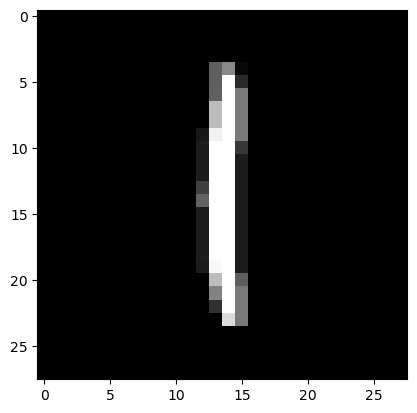

In [31]:
index = 2
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    x = images[index-1:index].to(device)
    y = labels[index-1].to(device)

    output = model(x)
    pred = output.argmax(dim=1).item()

print("Label:", y.item())
print("Prediction:", pred)
print(f"Probabilities: {np.round(output.numpy()[0],2)}")

plt.imshow(x.squeeze(), cmap="gray")
plt.show()

### SHAP

Build a small background set (reference distribution)

In [32]:
# Use ~50–200 images to keep it fast
background, _ = next(iter(train_loader))
background = background[:50].to(device)   # [50, 1, 28, 28]
background.shape

torch.Size([50, 1, 28, 28])

 Create the explainer

In [33]:
explainer = shap.DeepExplainer(model, background)

Pick a few samples to explain

In [39]:
test_samples, test_labels = next(iter(test_loader))
N = test_samples.size(0)
idx = torch.randperm(N)[:5]
test_samples = test_samples[idx]          # [5, 1, 28, 28]
test_labels = test_labels[idx]
test_samples.shape

torch.Size([5, 1, 28, 28])

Compute SHAP values

Returns a list with one array per data point: shap_values[data_index].shape == [1, 28, 28, 10]

In [40]:
shap_values = explainer.shap_values(test_samples)
shap_values[0].shape

(1, 28, 28, 10)

For the plot, we call image_plot(shap_values, pixel_values). This function needs input as:

shap_values: [numpy.array:]:
    List of numpy arrays of SHAP values. Each array has the shape [samples, W, H, C], and length equal to the number of model outputs.

pixel_values: numpy.array:
    Matrix of pixel values [samples, W, H, C] for each image. It should be the same shape as each array in the shap_values list of arrays.

In [41]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_samples.numpy(), 1, -1), 1, 2)
print(len(shap_numpy))     # 10
print(shap_numpy[0].shape) # (5, 28, 28, 1)
print(test_numpy.shape)    # (5, 28, 28, 1)

10
(5, 28, 28, 1)
(5, 28, 28, 1)


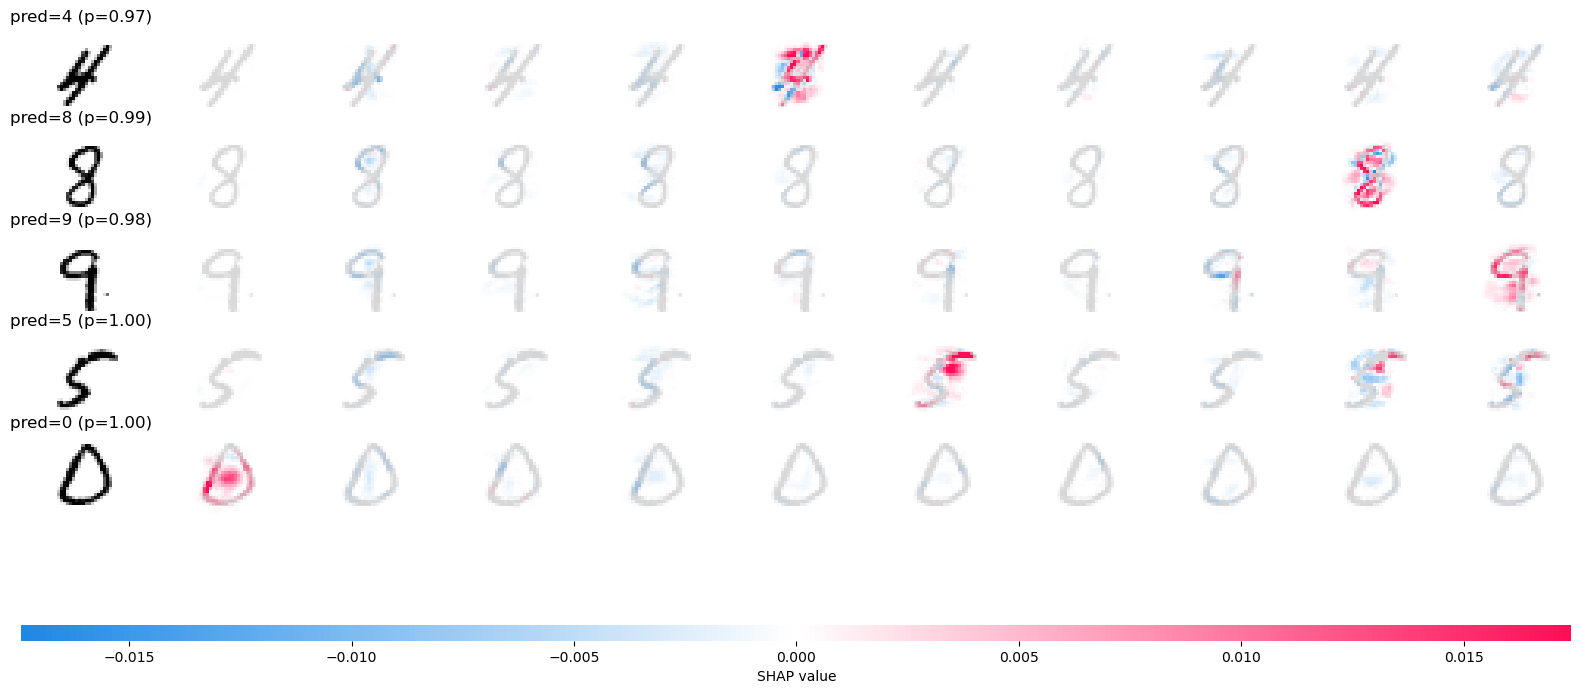

In [42]:
probs = model(test_samples).detach().numpy()      # [N,10]
pred_cls = probs.argmax(axis=1)
row_labels = [f"pred={int(pred_cls[i])} (p={probs[i, pred_cls[i]]:.2f})" for i in range(len(pred_cls))]

shap.image_plot(shap_numpy, -test_numpy, true_labels=row_labels)

The shape of the explainer.expected value corresponds to the number of classes. There is one expected prediction = baseline per class

In [43]:
explainer.expected_value

array([0.02032737, 0.1851374 , 0.08006676, 0.18173948, 0.07525377,
       0.06778049, 0.06224072, 0.11633369, 0.08466233, 0.12645797],
      dtype=float32)

In [44]:
sum(explainer.expected_value)

np.float32(0.99999994)